<a href="https://colab.research.google.com/github/KokYenZein/Deep-Learning--Image-Classification-using-CNN/blob/main/Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Deep-Learning--Image-Classification-using-CNN/Data/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Image Visualization

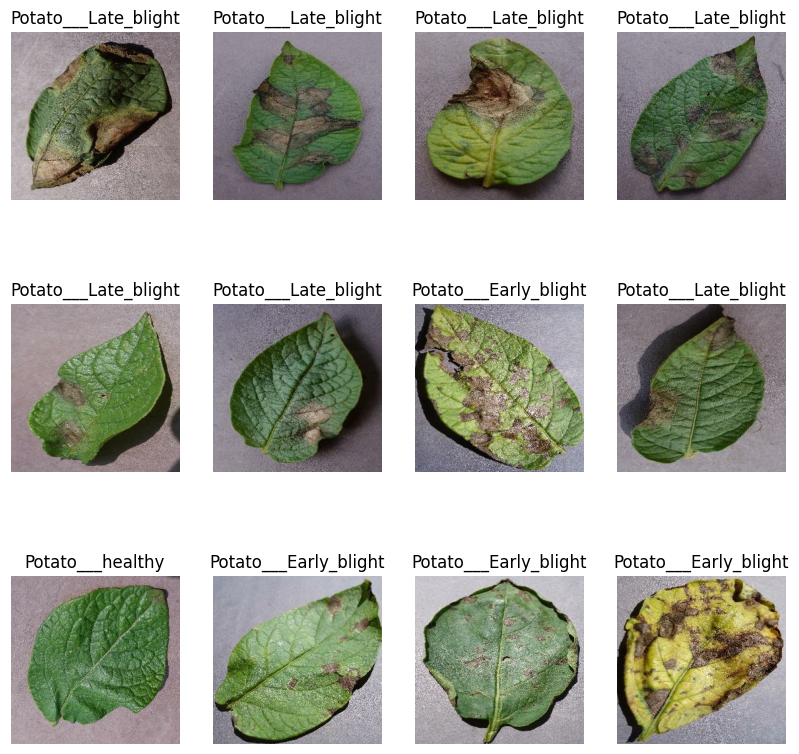

In [20]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Train Validation Test Split

In [21]:
# Train Validation Test Split
# 80% Train, 10% Validation, 10% Test
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

## Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating a Layer for Resizing and Normalization
normalize each image for each pixel from the range of 0 to 1.

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

Data Augmentation increases the accuracy of the model making it more robust to flipped, rotated, or zoomed images

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

# Modelling
Convulotion Neural Network is used with layers for resizing, normalization, and data augmentation

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [28]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

## Model Compilation
Optimizer: adam <br>
Losses: SparseCategorialCrossentropy <br>
Metric: Accuracy

In [30]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [32]:
EPOCHS = 50

In [33]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 324s 5s/step - loss: 0.9035 - accuracy: 0.5006 - val_loss: 0.9157 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 254s 5s/step - loss: 0.6897 - accuracy: 0.6931 - val_loss: 0.6271 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 259s 5s/step - loss: 0.4697 - accuracy: 0.8040 - val_loss: 0.3454 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 252s 5s/step - loss: 0.2992 - accuracy: 0.8815 - val_loss: 0.2324 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 251s 5s/step - loss: 0.2525 - accuracy: 0.8950 - val_loss: 0.3310 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 256s 5s/step - loss: 0.2669 - accuracy: 0.8815 - val_loss: 0.1504 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 252s 5s/step - loss: 0.1965 - accuracy: 0.9278 - val_loss: 0.1997 - val_accuracy: 0.9115
Epoch 8/50
54

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 18s 1s/step - loss: 0.0364 - accuracy: 0.9844


In [35]:
scores

[0.03636058792471886, 0.984375]

98% accuracy is achieved with low loss

# Plotting Loss and Accuracy curves

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [38]:
val_loss

[0.9157282710075378,
 0.6270968914031982,
 0.34544646739959717,
 0.23238998651504517,
 0.33100903034210205,
 0.1504000872373581,
 0.1996517926454544,
 0.1291784793138504,
 0.31154781579971313,
 0.3071143329143524,
 0.1088067963719368,
 0.20837567746639252,
 0.06208844855427742,
 0.057997044175863266,
 0.12633498013019562,
 0.28121742606163025,
 0.250784307718277,
 0.06667906790971756,
 0.14365853369235992,
 0.028748303651809692,
 0.2297106832265854,
 0.05271334946155548,
 0.12624162435531616,
 0.09414589405059814,
 0.20567025244235992,
 0.06695006787776947,
 0.03567167744040489,
 0.39897751808166504,
 0.04566023871302605,
 0.23858928680419922,
 0.03539746627211571,
 0.020265256986021996,
 0.06594214588403702,
 0.01731470786035061,
 0.07707561552524567,
 0.08375409990549088,
 0.12240713834762573,
 0.013585763983428478,
 0.10103658586740494,
 0.0401744581758976,
 0.07546975463628769,
 0.03572862967848778,
 0.10432551056146622,
 0.018813714385032654,
 0.07639310508966446,
 0.0676868632435

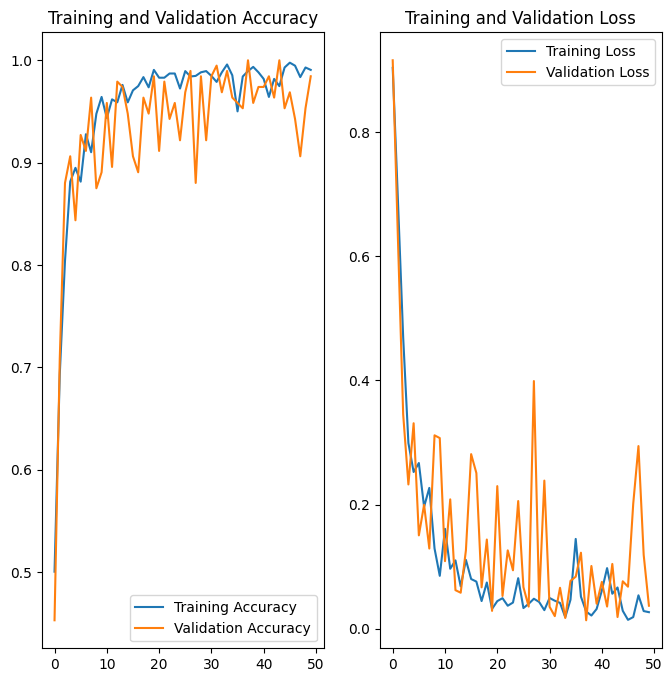

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


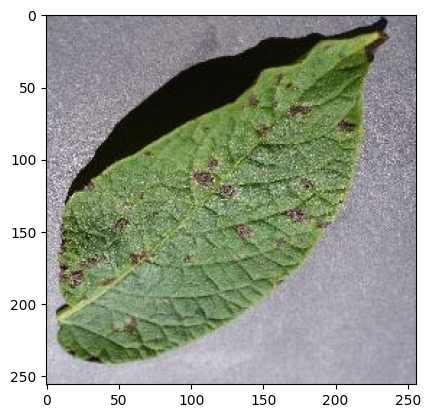

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 59ms/step


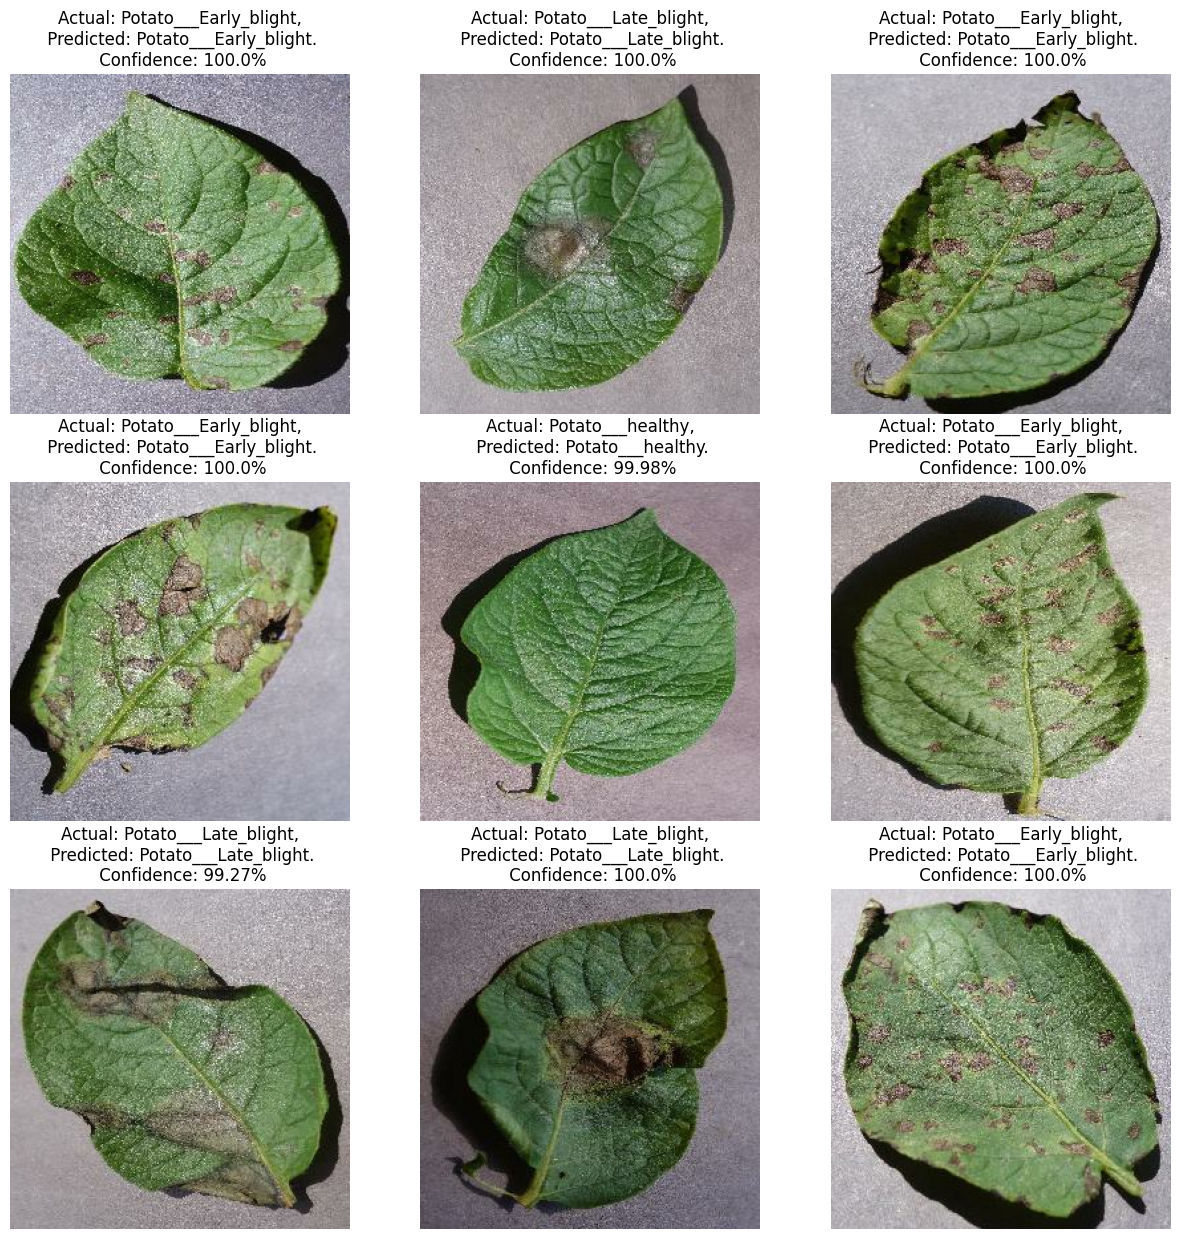

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving the model

In [43]:
model.save("model1")